In [6]:
# Imports & keys 

import os
from dotenv import load_dotenv
import glob
from langchain_anthropic import ChatAnthropic

os.chdir("/workspace")

# initialize API keys
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')

if openai_api_key:
    print(f"API Keys retrieved successfully")
else:
    print("API Keys not found")

API Keys retrieved successfully


## Grundidee der Datensynthese

Ausgangspunkt ist erneut die Knowledge-Base – also eine Sammlung von ausgewählten Artikeln.<br>
<br>
• Schritt 1: **Chunking**: Analog zum RAG-Ablauf splitten wir die Texte zunächst mit einem TextSplitter in einzelne Abschnitte (chunks).<br>
<br>
• Schritt 2: **Zufallssample**: Einer dieser chunks wird zufällig ausgewählt und dient als Startpunkt.<br>
<br>
• Schritt 3: **Kontextgeneration**: Per Cosine-Similarity suchen wir die semantisch ähnlichsten Nachbar-Chunks und fügen sie zu einem gemeinsamen Kontext zusammen. <br>
<br>
• Schritt 4: **Fragegenerierung**: Ein Query-Generator formuliert auf Basis dieses Kontexts passende Nutzerfragen – also die umgekehrte Logik zum Retrieving in RAG. <br>


## Finetuning-Parameter

Grundsätzlich erlaubt das *DeepEval* package sehr feines Tuning. Man kann z.B. festlegen:
<br>
<br>
• Wie viele chunks sollen pro Dokument extrahiert werden?
<br>
<br>
• Aus wie vielen chunks soll ein Kontext generiert werden?
<br>
<br>
• Wie soll die Ähnlichkeit zwischen chunks ermittelt werden?
<br>
<br>
• Wie genau soll das Post-Filtering stattfinden?
<br>
<br>
Für diese Demo übernehmen wir die default Einstellungen, mit einer Ausnahme:<br>
Für die chunk_size und den chunk_overlap (also wie klein sollen wie Abschnitte sein und wie sehr sollen sie sich überlappen) nehmen wir dieselben Werte, die wir auch im RAG-System verwendet haben. Damit wird sichergestellt, dass die Test- und Produktions­pipeline gleich sind. Außerdem wählen wir ein günstiges und schnelles LLM für die Fragengenerierung aus.

In [3]:
from deepeval.synthesizer import Synthesizer
from deepeval.synthesizer.config import StylingConfig, ContextConstructionConfig

# define the styling and context construction configurations using natural language
styling_config = StylingConfig(
    input_format= 
        "Natural, conversational questions in German that use everyday language rather than technical terminology." 
        "Questions should use paraphrases and pronouns, and occasionally contain mild irrelevant details." 
        "Each question addresses exactly one scientific aspect.",
    expected_output_format=
        "Concise answers in German, clearly structured citing evidence.",
    task=
        "Answering focused scientific, non-trivial queries that address specific aspects of medical, climate, environment, or technology topics.",
    scenario=
        "Science journalists, scientists, or curious non-experts seeking precise informationon a specific scientific topic they've encountered.",
)

In [4]:
# we use a cheap and fast llm
synthesizer = Synthesizer(
    model="gpt-4o-mini",
    styling_config=styling_config
)

# define the folder structure
data_dir = "data/example_data"
story_files = glob.glob(f'{data_dir}/*.txt')

# use the same chunking size as before
context_construction_config = ContextConstructionConfig(
    chunk_size=512,
    chunk_overlap=20
    )

# create golden questions and answers from the documents
synthesizer.generate_goldens_from_docs(
    document_paths=story_files,
    include_expected_output=True,
    context_construction_config=context_construction_config
    )

/usr/local/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[Confident AI Synthesizer Log] SUCCESS: Successfully deleted: .vector_db

[Confident AI Synthesizer Log] SUCCESS: Context Construction: Utilizing 40 out of 92 chunks.

[Golden(input='Wie wirken sich die steigenden Strompreise auf das Verbraucherverhalten aus, besonders wenn die Energieerzeugung niedrig ist?', actual_output=None, expected_output='Die steigenden Strompreise beeinflussen das Verbraucherverhalten nur geringfügig, da die hohen Börsenpreise für die meisten Haushalte nicht signifikant ins Gewicht fallen. In Phasen niedriger Energieerzeugung, wie während der Dunkelflaute, bleibt die Versorgungssicherheit dank ausreichend steuerbarer Kraftwerke gewährleistet. Daher ist vorsichtiger Umgang mit Eingriffen in den Strommarkt empfohlen, um unerwünschte Nebenwirkungen zu vermeiden.', context=[' Entsprechend hoch fielen die Strompreise der Day-Ahead-Auktion an der Strombörse EEX aus, sie erreichten knapp 378 Euro pro Megawattstunde (rund 38 Cent/kWh) https://www.energy-charts.info/charts/price_spot_market/chart.htm?l=de&amp;c=DE&amp;legendItems=4x0lg&amp;week=03&amp;year=2025[IV]. Zum Vergleich: 2024 lag der Börsenstrompreis im Jahresschnitt bei etw

In [2]:
# save the generated synthetic QA pairs to a pandas DataFrame
synthetic_qa_pairs = synthesizer.to_pandas()
synthetic_qa_pairs.to_csv("data/synthetic_qa_pairs/synthetic_qa_pairs_raw.csv", index=False)

NameError: name 'synthesizer' is not defined

In [14]:
synthetic_qa_pairs.head(5)

,input,actual_output,expected_output,context,retrieval_context,n_chunks_per_context,context_length,evolutions,context_quality,synthetic_input_quality,source_file
0,Wie wirken sich die steigenden Strompreise auf...,NaN,Die steigenden Strompreise beeinflussen das Ve...,[' Entsprechend hoch fielen die Strompreise de...,NaN,3,3997,['Reasoning'],NaN,1.0,data/example_data/07_Dunkelflauten_ Wie hohe S...
1,Wird die Dunkelflaute in den nächsten Tagen ei...,NaN,"Ja, die Dunkelflaute in den kommenden Tagen kö...",[' Entsprechend hoch fielen die Strompreise de...,NaN,3,3997,['In-Breadth'],NaN,0.6,data/example_data/07_Dunkelflauten_ Wie hohe S...
2,Wie wirken sich die steigenden Strompreise auf...,NaN,Die steigenden Strompreise beeinflussen das Ve...,[' Entsprechend hoch fielen die Strompreise de...,NaN,3,3997,['Reasoning'],NaN,1.0,data/example_data/07_Dunkelflauten_ Wie hohe S...
3,Wird die Dunkelflaute in den nächsten Tagen ei...,NaN,"Ja, die Dunkelflaute in den kommenden Tagen kö...",[' Entsprechend hoch fielen die Strompreise de...,NaN,3,3997,['In-Breadth'],NaN,0.6,data/example_data/07_Dunkelflauten_ Wie hohe S...
4,Wie beeinflussen verschiedene Arten von Stroms...,NaN,Stromspeicher beeinflussen die Marktpreise erh...,"['ringert werden, wenn entweder das Angebot au...",NaN,3,3980,['Comparative'],NaN,0.8,data/example_data/07_Dunkelflauten_ Wie hohe S...


## LLM-basiertes post-hoc filtern
<br>
Die ersten synthetischen Fragen machen bereits einen soliden Eindruck, sind jedoch noch nicht perfekt. Darum lassen wir sie von einem zweiten LLM gegen drei klar definierte Bewertungs­kriterien prüfen, die in 3 separaten Prompts formuliert wurden:
<br>
<br>
In diesem Fall geht es v.a. um folgende Punkte: 
<br>
<br>
- Wie genau lässt sich die Fragen mit dem bereitgestellten Kontext beantworten?
<br>
<br>
- Wie relevant sind die Fragen überhaupt für das Zielpublikum, also Wissenschaftsjournalist*innen oder interessierte Laien?
<br>
<br>
- Inwiefern ergibt die Frage ohne Kontext überhaupt Sinn? 
<br>
<br>
Das Bewertungs-LLM vergibt für jedes Kriterium **einen Score von 1 bis 5**. Diese Werte bilden anschließend die Grundlage für unseren Qualitäts­filter.

In [13]:
# we randomly choose 60 of those questions 
synthetic_qa_pairs_sample = synthetic_qa_pairs.sample(n=60, random_state=123)  

In [15]:
from data.prompts.evaluation_prompts import (
    question_groundedness_critique_prompt,
    question_relevance_critique_prompt,
    question_standalone_critique_prompt
)

evaluation_llm = ChatAnthropic(
        model_name="claude-3-5-haiku-20241022",
        temperature=0,
        max_tokens=512,
        verbose=False
    )

# Create a dictionary of critique prompts
critique_prompts = {
    "groundedness": question_groundedness_critique_prompt,
    "relevance": question_relevance_critique_prompt,
    "standalone": question_standalone_critique_prompt
}

from src.utils.synth_data_creation import evaluate_qa_pairs

# Evaluate the synthetic QA pairs using the critique prompts
eval_qa_pairs = evaluate_qa_pairs(
    synthetic_qa_pairs_sample, 
    critique_prompts, 
    evaluation_llm
    )

# save the evaluated QA pairs to a CSV file, because this is the longest and most expensive step
eval_qa_pairs.to_csv("data/synthetic_qa_pairs/synthetic_qa_pairs_evaluated.csv", index=False)

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating critique for each QA pair...


  0%|          | 0/60 [00:00<?, ?it/s]/workspace/src/utils/synth_data_creation.py:39: LangChainDeprecationWarning: The method `BaseChatModel.predict_messages` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  evaluation = chat_model.predict_messages([HumanMessage(content=prompt)])
100%|██████████| 60/60 [18:55<00:00, 18.93s/it]

Critique generation completed.


In [21]:
# this is what a typical output looks like
eval_qa_pairs.sample(1).to_dict()

{'input': {288: 'Wie könnte ein KI-Chatbot helfen, rationale Argumente gegen gängige Verschwörungstheorien zu liefern, und welche Auswirkungen könnte das auf die Überzeugungen der Menschen haben?'},
 'actual_output': {288: None},
 'expected_output': {288: 'Ein KI-Chatbot kann helfen, indem er in gezielten Gesprächen Fakten und rationale Argumente vermittelt, die auf evidenzbasierter Forschung beruhen. Laut der Studie in der Fachzeitschrift „Science“ zeigen die Ergebnisse, dass Gespräche mit KI-Chatbots die Zustimmung zu Verschwörungstheorien erheblich senken können. Die Studie ergab, dass individuelle Anpassungen der Argumente durch den KI-Chatbot effektiver sind als bisher angenommen.\n\nAuswirkungen auf die Überzeugungen der Menschen sind signifikant: Obwohl etwa 75 % der Teilnehmer nach der Intervention immer noch an Verschwörungstheorien glauben, war die Überzeugung deutlich weniger extrem, was einen großen Effekt darstellt. Diese Ergebnisse deuten darauf hin, dass rationale Argume

In [25]:
from src.utils.synth_data_creation import process_evaluation_scores

# eventually, we compute an overall average score (groundedness, relevance, standalone) for each question and remove the bottom 15% of questions based on this score
filtered_df = process_evaluation_scores(
    eval_qa_pairs,
    groundedness_weight=0.35,
    standalone_weight=0.35,
    relevance_weight=0.3,
    bottom_percent_remove=15
)

# save the final dataset
filtered_df.to_csv("data/synthetic_qa_pairs/synthetic_qa_pairs_filtered.csv", index=False)

## Diversität prüfen  

Und dann bin ich fast fertig. Die Qualität der Frage-Antwort-Paare ist wichtig, doch die Diversität der Fragen ist entscheidender. 

Ein Testset mit vielen verschiedenen, wenn auch qualitativ nicht perfekten Fragen ist wertvoller als eines, das zwar sehr hochwertige, aber sehr ähnliche Fragen enthält. 

Daher prüfen wir nun die **Diversität** der Fragen.  <br>
Ein weniger perfektes, aber breit gestreutes Set deckt deutlich mehr Fehlerquellen auf als ein sauberes, jedoch monotones Set.
<br>
### Messgröße  
Dafür nutzen wir erneut die **mittlere paarweise Cosine-Similarity**. Als rule-of-thumb kann man sich an folgende Werte orientieren:
<br>
| Richtwert | Interpretation |
|-----------|----------------|
| **> 0.60** | starke Redundanz → kaum neue Fehlerfälle |
| **< 0.40** | genügend Diversität für praxisnahe RAG-Tests |


Batches:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Mean similarity: 0.2890
Std  similarity: 0.2712


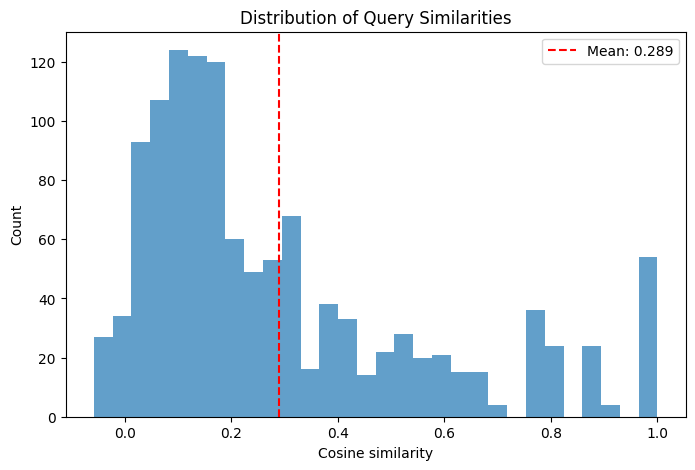

In [24]:
from src.utils.synth_data_creation import analyze_semantic_similarity

sims, sim_matrix = analyze_semantic_similarity(filtered_df)

## Zusammenfassung unseres Mini-Sets  
* Mean = **0.289** – also grundsätzlich gut.  
* Die Verteilung zeigt jedoch mehrere Cluster sehr ähnlicher Fragen.  

Das ist nicht weiter überraschend, die Queries stammen schließlich aus nur sehr wenigen Artikeln.<br>  
Allgemein kann man jedoch sagen: Je heterogener die Knowledge-Base, desto vielfältiger die Fragen.<br>
Andernfalls hilft gezieltes *De-Duplizieren* (also einige Fragen, die sich sehr ähnlich sind, entfernen), das würde aber den Rahmen dieses Workshops sprengen.<br>
<br>
Am Ende sollte man die Fragen trotzdem noch manuell prüfen.<br>
So bekommt man ein Gefühl für Stil, Tiefe und Kontext, und man kann offensichtlich unbrauchbare oder schlechte Fragen direkt entfernen.<br>
<br>
Hier noch ein paar Quellen und weiterführende Links:<br>
<br>
 [Hintergrund zur Erstellung synthetische Datensets](https://www.confident-ai.com/blog/the-definitive-guide-to-synthetic-data-generation-using-llms)<br>
 [deepeval Doku](https://deepeval.com/docs/synthesizer-introduction)<br>
 [Ein bisschen theoretischer Hintergrund in leicht aufbereitet](https://msukhareva.substack.com/p/synthetic-datasets-for-applied-ai)<br>
